# Chapter 3

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lng_df = pd.read_hdf('lng_df.h5', key='lng_df')

feature_names = ['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30',
                 'ma50', 'rsi50', 'ma200', 'rsi200']

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

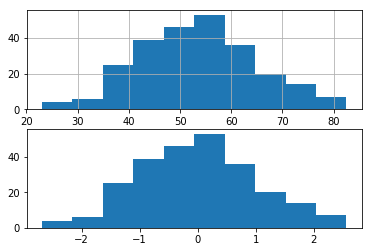

In [5]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
#train_features = train_features.iloc[:, :-4]
#test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [6]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.8466947018832736
-0.4795938139878307

n_neighbors = 3
train, test scores
0.7460290659029947
-0.3877775433094155

n_neighbors = 4
train, test scores
0.6774680180258243
-0.42089610553014123

n_neighbors = 5
train, test scores
0.6060472506952792
-0.32875909480248056

n_neighbors = 6
train, test scores
0.5415764129306011
-0.20691805330966173

n_neighbors = 7
train, test scores
0.5235618047002555
-0.13273130039173409

n_neighbors = 8
train, test scores
0.4898841476506851
-0.12154943936106365

n_neighbors = 9
train, test scores
0.4761422423446282
-0.12999331894628785

n_neighbors = 10
train, test scores
0.4543668446026158
-0.09737826569131869

n_neighbors = 11
train, test scores
0.41462630514787246
-0.06486867646029082

n_neighbors = 12
train, test scores
0.38671866345020134
-0.09805243475233372



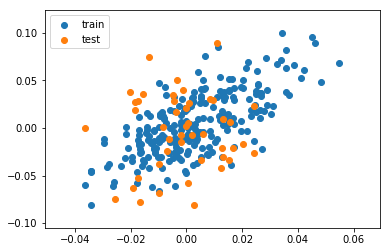

In [7]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=10)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

In [16]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=10)

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0388
Epoch 2/10
250/250 [==============================] - 0s 206us/step - loss: 0.0119
Epoch 3/10
250/250 [==============================] - 0s 192us/step - loss: 0.0074
Epoch 4/10
250/250 [==============================] - 0s 205us/step - loss: 0.0035
Epoch 5/10
250/250 [==============================] - 0s 302us/step - loss: 0.0029
Epoch 6/10
250/250 [==============================] - 0s 284us/step - loss: 0.0021
Epoch 7/10
250/250 [==============================] - 0s 213us/step - loss: 0.0019
Epoch 8/10
250/250 [==============================] - 0s 171us/step - loss: 0.0015
Epoch 9/10
250/250 [==============================] - 0s 159us/step - loss: 0.0014
Epoch 10/10
250/250 [==============================] - 0s 180us/step - loss: 0.0013


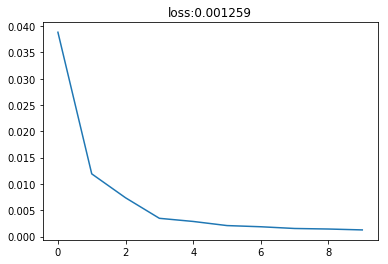

In [17]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

-0.07731733416787034
-0.09107435935093777


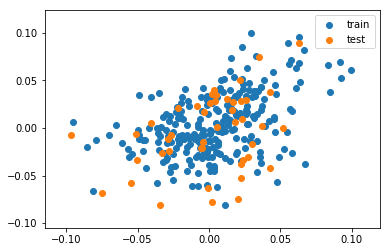

In [18]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

In [19]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x1a392b68c8>


Epoch 1/25
250/250 [==============================] - 1s 3ms/step - loss: 0.6653
Epoch 2/25
250/250 [==============================] - 0s 532us/step - loss: 0.3057
Epoch 3/25
250/250 [==============================] - 0s 200us/step - loss: 0.2258
Epoch 4/25
250/250 [==============================] - 0s 211us/step - loss: 0.1687
Epoch 5/25
250/250 [==============================] - 0s 177us/step - loss: 0.1571
Epoch 6/25
250/250 [==============================] - 0s 189us/step - loss: 0.1208
Epoch 7/25
250/250 [==============================] - 0s 164us/step - loss: 0.0979
Epoch 8/25
250/250 [==============================] - 0s 177us/step - loss: 0.0767
Epoch 9/25
250/250 [==============================] - 0s 163us/step - loss: 0.0590
Epoch 10/25
250/250 [==============================] - 0s 163us/step - loss: 0.0535
Epoch 11/25
250/250 [==============================] - 0s 185us/step - loss: 0.0498
Epoch 12/25
250/250 [==============================] - 0s 212us/step - loss: 0.0455
Epo

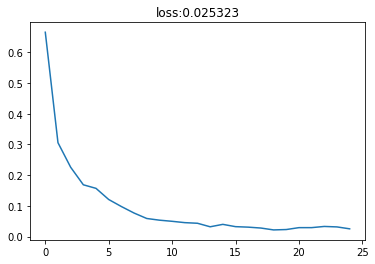

In [20]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.022044587189706033
-0.5936254847734632


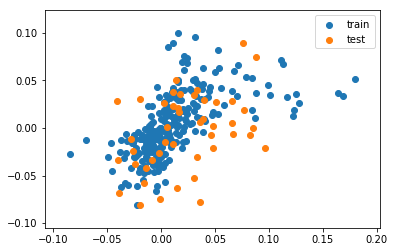

In [21]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

Epoch 1/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0796
Epoch 2/25
250/250 [==============================] - 0s 243us/step - loss: 0.0366
Epoch 3/25
250/250 [==============================] - 0s 271us/step - loss: 0.0203
Epoch 4/25
250/250 [==============================] - 0s 239us/step - loss: 0.0146
Epoch 5/25
250/250 [==============================] - 0s 185us/step - loss: 0.0107
Epoch 6/25
250/250 [==============================] - 0s 206us/step - loss: 0.0069
Epoch 7/25
250/250 [==============================] - 0s 213us/step - loss: 0.0066
Epoch 8/25
250/250 [==============================] - 0s 180us/step - loss: 0.0082
Epoch 9/25
250/250 [==============================] - 0s 190us/step - loss: 0.0051
Epoch 10/25
250/250 [==============================] - 0s 171us/step - loss: 0.0052
Epoch 11/25
250/250 [==============================] - 0s 168us/step - loss: 0.0051
Epoch 12/25
250/250 [==============================] - 0s 155us/step - loss: 0.0039
Epo

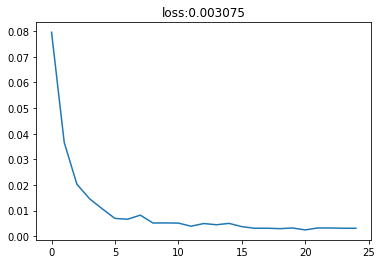

In [22]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [23]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[ 0.00160556  0.04202281  0.00557752  0.00245929 -0.00937053]


0.42707163873716936
0.030036202631679942


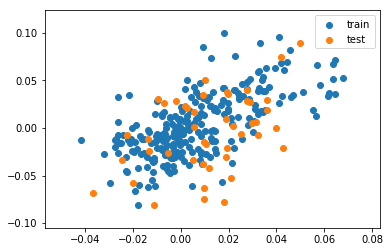

In [24]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()